# Streaming Simulation Progress for Digital Twins

This notebook demonstrates how to use NeqSim's new **streaming progress callbacks** for real-time visualization during process simulation. This feature is essential for:

- **Digital Twin Dashboards** - Live updates as each unit operation completes
- **Debugging** - Watch convergence progress in recycle loops
- **Training/Education** - Students see simulation progress step-by-step
- **Long Simulations** - Progress indication for complex process models

## Key Methods

| Method | Description |
|--------|-------------|
| `setProgressListener(listener)` | Set a full listener interface for detailed callbacks |
| `runWithCallback(callback)` | Simple callback for each unit (Python-friendly) |
| `runWithProgress(id)` | Run with progress notifications to registered listener |

> **Note**: If you get an AttributeError for `runWithCallback`, restart the kernel to load the updated NeqSim JAR.

In [1]:
# Import NeqSim via JPype - Direct Java Access
import neqsim
from neqsim import jneqsim
import jpype
import jpype.imports  # Enable java imports

# Import Java classes using the jneqsim gateway
SystemSrkEos = jneqsim.thermo.system.SystemSrkEos
ProcessSystem = jneqsim.process.processmodel.ProcessSystem
ProcessModule = jneqsim.process.processmodel.ProcessModule
Stream = jneqsim.process.equipment.stream.Stream
Separator = jneqsim.process.equipment.separator.Separator
Compressor = jneqsim.process.equipment.compressor.Compressor
Cooler = jneqsim.process.equipment.heatexchanger.Cooler
Heater = jneqsim.process.equipment.heatexchanger.Heater
ThrottlingValve = jneqsim.process.equipment.valve.ThrottlingValve
Mixer = jneqsim.process.equipment.mixer.Mixer

# Import Java UUID after enabling imports
from java.util import UUID

print("NeqSim imported successfully!")
print(f"JAR location: {neqsim.__file__}")

NeqSim imported successfully!
JAR location: c:\Users\ESOL\Documents\GitHub\neqsim2\.venv\Lib\site-packages\neqsim\__init__.py


## 1. Build a Gas Processing Plant Model

We'll create a realistic gas processing facility with:
- Inlet separation
- Two-stage compression with intercooling
- Gas dehydration (simplified)
- Export compression

In [3]:
# Create the feed fluid - typical wellstream composition
fluid = SystemSrkEos(273.15 + 25.0, 50.0)
fluid.addComponent("nitrogen", 0.02)
fluid.addComponent("CO2", 0.015)
fluid.addComponent("methane", 0.75)
fluid.addComponent("ethane", 0.08)
fluid.addComponent("propane", 0.05)
fluid.addComponent("i-butane", 0.015)
fluid.addComponent("n-butane", 0.02)
fluid.addComponent("i-pentane", 0.01)
fluid.addComponent("n-pentane", 0.01)
fluid.addComponent("n-hexane", 0.015)
fluid.addComponent("water", 0.015)
fluid.setMixingRule("classic")

print(f"Feed composition: {fluid.getNumberOfComponents()} components")

Feed composition: 11 components


In [4]:
# Build the process system
process = ProcessSystem("Gas Processing Plant")

# Feed stream from wellhead
feed = Stream("Well Feed", fluid)
feed.setFlowRate(50000.0, "kg/hr")
feed.setTemperature(80.0, "C")
feed.setPressure(65.0, "bara")
process.add(feed)

# Inlet heater (maintain flow assurance)
inlet_heater = Heater("Inlet Heater", feed)
inlet_heater.setOutTemperature(75.0, "C")
process.add(inlet_heater)

# HP Separator - remove free water and liquids
hp_separator = Separator("HP Separator", inlet_heater.getOutletStream())
process.add(hp_separator)

# 1st Stage Compressor
comp1 = Compressor("1st Stage Compressor", hp_separator.getGasOutStream())
comp1.setOutletPressure(100.0)
comp1.setPolytropicEfficiency(0.75)
process.add(comp1)

# Intercooler 1
cooler1 = Cooler("Intercooler 1", comp1.getOutletStream())
cooler1.setOutTemperature(35.0, "C")
process.add(cooler1)

# Interstage scrubber
scrubber1 = Separator("Interstage Scrubber", cooler1.getOutletStream())
process.add(scrubber1)

# 2nd Stage Compressor
comp2 = Compressor("2nd Stage Compressor", scrubber1.getGasOutStream())
comp2.setOutletPressure(150.0)
comp2.setPolytropicEfficiency(0.75)
process.add(comp2)

# Aftercooler
cooler2 = Cooler("Aftercooler", comp2.getOutletStream())
cooler2.setOutTemperature(30.0, "C")
process.add(cooler2)

# Dehydration separator (simplified TEG contactor)
dehy_sep = Separator("Dehydration Drum", cooler2.getOutletStream())
process.add(dehy_sep)

# Export Compressor
export_comp = Compressor("Export Compressor", dehy_sep.getGasOutStream())
export_comp.setOutletPressure(200.0)
export_comp.setPolytropicEfficiency(0.78)
process.add(export_comp)

# Export Cooler
export_cooler = Cooler("Export Cooler", export_comp.getOutletStream())
export_cooler.setOutTemperature(25.0, "C")
process.add(export_cooler)

print(f"Process system built with {process.size()} unit operations")

Process system built with 11 unit operations


## 2. Run with Simple Callback (Python Function)

The simplest approach uses `runWithCallback()` with a Python function that receives each completed unit operation.

In [6]:
# Collect results as simulation progresses
results = {
    'unit_name': [],
    'temperature_C': [],
    'pressure_bara': [],
    'power_kW': [],
    'duty_kW': []
}

def on_unit_complete(unit):
    """Callback invoked after each unit operation runs"""
    unit_name = str(unit.getName())
    results['unit_name'].append(unit_name)
    
    # Get outlet conditions
    try:
        out_stream = unit.getOutletStream()
        results['temperature_C'].append(float(out_stream.getTemperature('C')))
        results['pressure_bara'].append(float(out_stream.getPressure('bara')))
    except:
        results['temperature_C'].append(None)
        results['pressure_bara'].append(None)
    
    # Get power/duty
    try:
        class_name = str(unit.getClass().getSimpleName())
        if 'Compressor' in class_name:
            results['power_kW'].append(float(unit.getPower('kW')))
            results['duty_kW'].append(0.0)
        elif 'Cooler' in class_name or 'Heater' in class_name:
            results['power_kW'].append(0.0)
            results['duty_kW'].append(float(unit.getDuty()) / 1000.0)
        else:
            results['power_kW'].append(0.0)
            results['duty_kW'].append(0.0)
    except:
        results['power_kW'].append(0.0)
        results['duty_kW'].append(0.0)
    
    # Print progress
    print(f"✓ {unit_name}")

# Create a Java Consumer from Python function
@jpype.JImplements('java.util.function.Consumer')
class PyConsumer:
    def __init__(self, callback):
        self.callback = callback
    
    @jpype.JOverride
    def accept(self, obj):
        self.callback(obj)

# Run with callback
print("Starting simulation with progress callbacks...\n")
process.runWithCallback(PyConsumer(on_unit_complete))
print("\n✅ Simulation complete!")

Starting simulation with progress callbacks...

✓ Well Feed
✓ Inlet Heater
✓ HP Separator
✓ 1st Stage Compressor
✓ Intercooler 1
✓ Interstage Scrubber
✓ 2nd Stage Compressor
✓ Aftercooler
✓ Dehydration Drum
✓ Export Compressor
✓ Export Cooler

✅ Simulation complete!


## 3. Visualize Results with Live Plotting

With the collected data, we can create visualizations. In a real digital twin, these would update in real-time during the callback.

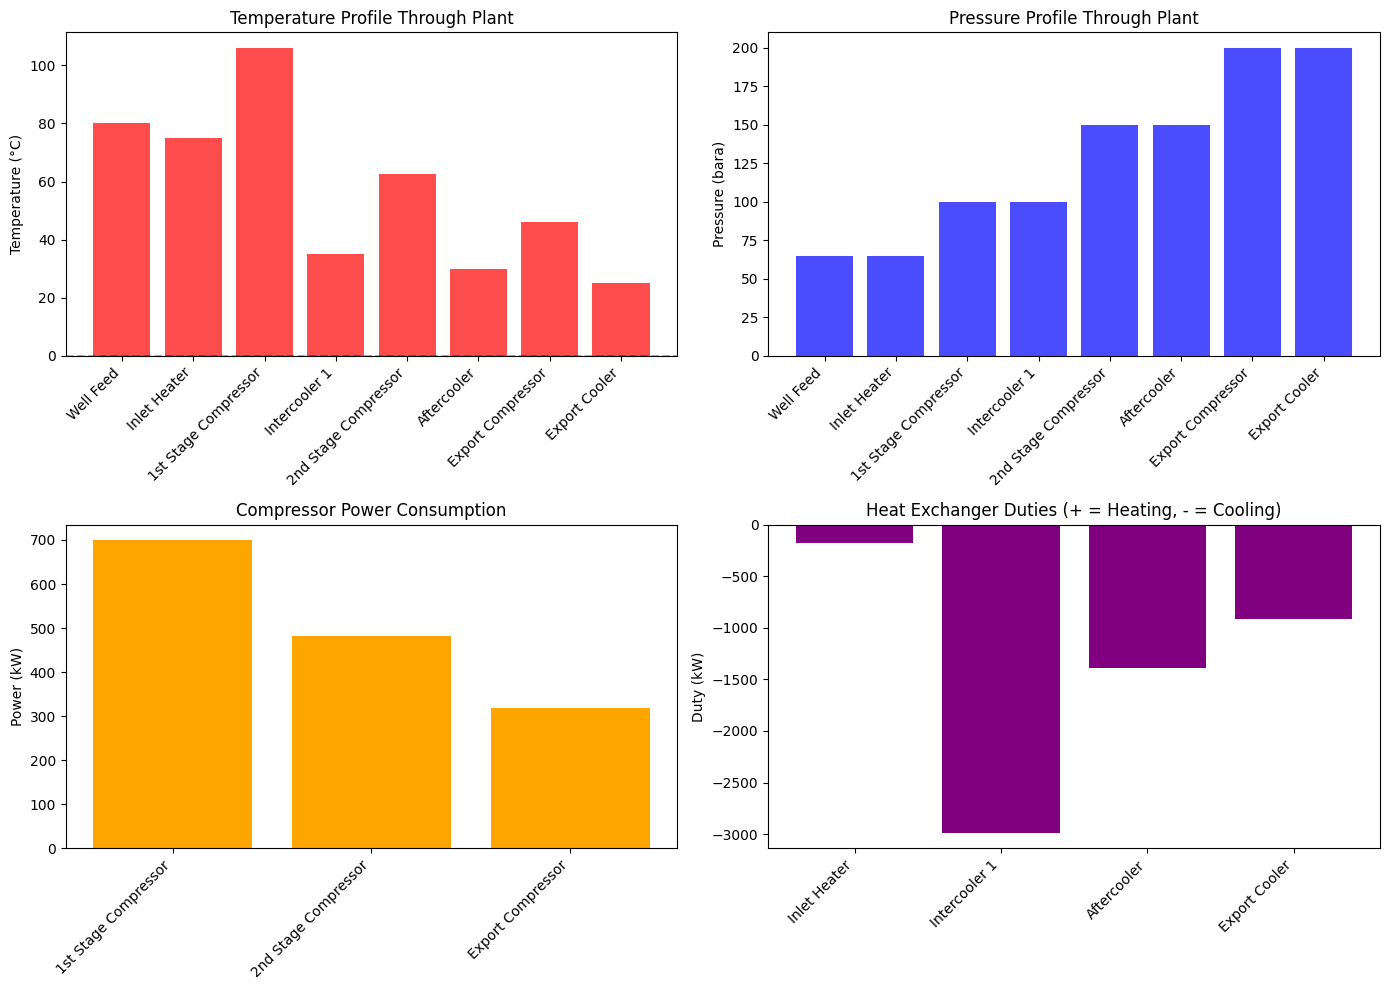


=== Plant Summary ===
Total Compressor Power: 1,501 kW
Total Cooling Duty: 5,469 kW
Total Heating Duty: 0 kW


In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame from results
df = pd.DataFrame(results)
df = df.dropna(subset=['temperature_C', 'pressure_bara'])

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Temperature profile
axes[0, 0].bar(range(len(df)), df['temperature_C'], color='red', alpha=0.7)
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_title('Temperature Profile Through Plant')
axes[0, 0].set_xticks(range(len(df)))
axes[0, 0].set_xticklabels(df['unit_name'], rotation=45, ha='right')
axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Pressure profile
axes[0, 1].bar(range(len(df)), df['pressure_bara'], color='blue', alpha=0.7)
axes[0, 1].set_ylabel('Pressure (bara)')
axes[0, 1].set_title('Pressure Profile Through Plant')
axes[0, 1].set_xticks(range(len(df)))
axes[0, 1].set_xticklabels(df['unit_name'], rotation=45, ha='right')

# Compressor power
power_df = df[df['power_kW'] > 0]
if len(power_df) > 0:
    axes[1, 0].bar(range(len(power_df)), power_df['power_kW'], color='orange')
    axes[1, 0].set_ylabel('Power (kW)')
    axes[1, 0].set_title('Compressor Power Consumption')
    axes[1, 0].set_xticks(range(len(power_df)))
    axes[1, 0].set_xticklabels(power_df['unit_name'], rotation=45, ha='right')

# Heat duties
duty_df = df[df['duty_kW'] != 0]
if len(duty_df) > 0:
    colors = ['green' if d > 0 else 'purple' for d in duty_df['duty_kW']]
    axes[1, 1].bar(range(len(duty_df)), duty_df['duty_kW'], color=colors)
    axes[1, 1].set_ylabel('Duty (kW)')
    axes[1, 1].set_title('Heat Exchanger Duties (+ = Heating, - = Cooling)')
    axes[1, 1].set_xticks(range(len(duty_df)))
    axes[1, 1].set_xticklabels(duty_df['unit_name'], rotation=45, ha='right')
    axes[1, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
total_power = df['power_kW'].sum()
total_cooling = abs(df[df['duty_kW'] < 0]['duty_kW'].sum())
total_heating = df[df['duty_kW'] > 0]['duty_kW'].sum()

print(f"\n=== Plant Summary ===")
print(f"Total Compressor Power: {total_power:,.0f} kW")
print(f"Total Cooling Duty: {total_cooling:,.0f} kW")
print(f"Total Heating Duty: {total_heating:,.0f} kW")

## 4. Using the Full SimulationProgressListener Interface

For more control, implement the full `SimulationProgressListener` interface which provides:
- Unit completion callbacks with index and iteration info
- Iteration completion callbacks for recycle convergence monitoring
- Error handling with optional continuation

In [6]:
# Implement the full listener interface
@jpype.JImplements('neqsim.process.processmodel.ProcessSystem$SimulationProgressListener')
class DetailedProgressListener:
    def __init__(self):
        self.unit_times = []
        self.iteration_count = 0
        import time
        self.start_time = time.time()
    
    @jpype.JOverride
    def onUnitComplete(self, unit, unitIndex, totalUnits, iterationNumber):
        import time
        elapsed = time.time() - self.start_time
        progress = (unitIndex + 1) / totalUnits * 100
        print(f"  [{progress:5.1f}%] Iter {iterationNumber}: {str(unit.getName())} "
              f"({unitIndex+1}/{totalUnits}) - {elapsed:.2f}s")
    
    @jpype.JOverride
    def onIterationComplete(self, iterationNumber, converged, recycleError):
        self.iteration_count = iterationNumber
        status = "✓ CONVERGED" if converged else f"... error={recycleError:.2e}"
        print(f"\n=== Iteration {iterationNumber} complete {status} ===\n")
    
    @jpype.JOverride
    def onUnitError(self, unit, exception):
        print(f"❌ ERROR in {str(unit.getName())}: {str(exception.getMessage())}")
        return False  # Abort on error

# Create a new process for demonstration
process2 = ProcessSystem("Gas Plant v2")

# Rebuild the same process
fluid2 = SystemSrkEos(273.15 + 30.0, 60.0)
fluid2.addComponent("methane", 0.85)
fluid2.addComponent("ethane", 0.08)
fluid2.addComponent("propane", 0.04)
fluid2.addComponent("n-butane", 0.02)
fluid2.addComponent("water", 0.01)
fluid2.setMixingRule("classic")

feed2 = Stream("Feed", fluid2)
feed2.setFlowRate(30000.0, "kg/hr")
feed2.setTemperature(60.0, "C")
feed2.setPressure(50.0, "bara")
process2.add(feed2)

sep2 = Separator("Inlet Sep", feed2)
process2.add(sep2)

comp_a = Compressor("Comp A", sep2.getGasOutStream())
comp_a.setOutletPressure(100.0)
process2.add(comp_a)

cool_a = Cooler("Cooler A", comp_a.getOutletStream())
cool_a.setOutTemperature(30.0, "C")
process2.add(cool_a)

comp_b = Compressor("Comp B", cool_a.getOutletStream())
comp_b.setOutletPressure(180.0)
process2.add(comp_b)

cool_b = Cooler("Cooler B", comp_b.getOutletStream())
cool_b.setOutTemperature(25.0, "C")
process2.add(cool_b)

# Set the detailed listener
listener = DetailedProgressListener()
process2.setProgressListener(listener)

# Run with progress
print("Running with full progress listener...\n")
from java.util import UUID
process2.runWithProgress(UUID.randomUUID())

print(f"\nTotal iterations: {listener.iteration_count}")

Running with full progress listener...

  [ 16.7%] Iter 1: Feed (1/6) - 0.01s
  [ 33.3%] Iter 1: Inlet Sep (2/6) - 0.01s
  [ 50.0%] Iter 1: Comp A (3/6) - 0.01s
  [ 66.7%] Iter 1: Cooler A (4/6) - 0.01s
  [ 83.3%] Iter 1: Comp B (5/6) - 0.02s
  [100.0%] Iter 1: Cooler B (6/6) - 0.02s

=== Iteration 1 complete ✓ CONVERGED ===


Total iterations: 1


## 5. Real-Time Dashboard with IPython Widgets

For interactive notebooks, combine callbacks with IPython widgets for a live dashboard experience.

In [7]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Create output widget for live updates
out = widgets.Output()

# Data collection
live_data = {'names': [], 'temps': [], 'pressures': []}

def live_callback(unit):
    """Update live dashboard"""
    name = str(unit.getName())
    live_data['names'].append(name)
    
    try:
        out_stream = unit.getOutletStream()
        live_data['temps'].append(float(out_stream.getTemperature('C')))
        live_data['pressures'].append(float(out_stream.getPressure('bara')))
    except:
        live_data['temps'].append(0)
        live_data['pressures'].append(0)
    
    # Update display
    with out:
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Temperature
        ax1.plot(live_data['temps'], 'ro-', markersize=8)
        ax1.set_ylabel('Temperature (°C)')
        ax1.set_title(f'Temperature Profile - {len(live_data["names"])} units')
        ax1.grid(True, alpha=0.3)
        
        # Pressure
        ax2.plot(live_data['pressures'], 'bs-', markersize=8)
        ax2.set_ylabel('Pressure (bara)')
        ax2.set_title('Pressure Profile')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nLast completed: {name}")

# Display the output widget
display(out)

# Reset data
live_data = {'names': [], 'temps': [], 'pressures': []}

# Run with live updates
process.runWithCallback(PyConsumer(live_callback))

print("\n🎉 Live simulation complete!")

Output()


🎉 Live simulation complete!


## 6. ProcessModule Support

The callback system also works with `ProcessModule` for hierarchical process models. The listener is automatically propagated to all child ProcessSystems.

In [9]:
# ProcessModule is available from jneqsim
ProcessModule = jneqsim.process.processmodel.ProcessModule

# Create a modular process
compression_module = ProcessSystem("Compression Train")
dehydration_module = ProcessSystem("Dehydration Unit")

# Build compression module
fluid_comp = SystemSrkEos(273.15 + 30.0, 40.0)
fluid_comp.addComponent("methane", 0.90)
fluid_comp.addComponent("ethane", 0.07)
fluid_comp.addComponent("propane", 0.03)
fluid_comp.setMixingRule("classic")

comp_feed = Stream("Comp Feed", fluid_comp)
comp_feed.setFlowRate(20000.0, "kg/hr")
comp_feed.setTemperature(35.0, "C")
comp_feed.setPressure(40.0, "bara")
compression_module.add(comp_feed)

stage1_comp = Compressor("Stage 1", comp_feed)
stage1_comp.setOutletPressure(80.0)
compression_module.add(stage1_comp)

stage1_cool = Cooler("IC-1", stage1_comp.getOutletStream())
stage1_cool.setOutTemperature(35.0, "C")
compression_module.add(stage1_cool)

stage2_comp = Compressor("Stage 2", stage1_cool.getOutletStream())
stage2_comp.setOutletPressure(150.0)
compression_module.add(stage2_comp)

# Build dehydration module
dehy_feed = Stream("Dehy Feed", stage2_comp.getOutletStream().getFluid())
dehy_feed.setFlowRate(20000.0, "kg/hr")
dehy_feed.setTemperature(80.0, "C")
dehy_feed.setPressure(150.0, "bara")
dehydration_module.add(dehy_feed)

dehy_cool = Cooler("Dehy Cooler", dehy_feed)
dehy_cool.setOutTemperature(25.0, "C")
dehydration_module.add(dehy_cool)

dehy_drum = Separator("Dehy Drum", dehy_cool.getOutletStream())
dehydration_module.add(dehy_drum)

# Create the master module
master_module = ProcessModule("Gas Processing Facility")
master_module.add(compression_module)
master_module.add(dehydration_module)

# Track units across both modules
module_results = []

def module_callback(unit):
    module_results.append(str(unit.getName()))
    print(f"  Module unit: {unit.getName()}")

print("Running modular process with callbacks...\n")
master_module.runWithCallback(PyConsumer(module_callback))

print(f"\n✅ Completed {len(module_results)} unit operations across modules")

Running modular process with callbacks...

  Module unit: Comp Feed
  Module unit: Stage 1
  Module unit: IC-1
  Module unit: Stage 2
  Module unit: Dehy Feed
  Module unit: Dehy Cooler
  Module unit: Dehy Drum

✅ Completed 7 unit operations across modules


## 7. Digital Twin Application Pattern

Here's a complete pattern for building a digital twin with live data updates:

In [10]:
class DigitalTwinMonitor:
    """Digital twin monitor with streaming progress"""
    
    def __init__(self, process_system):
        self.process = process_system
        self.history = []
        self.current_run = None
    
    def update_from_measurements(self, measurements):
        """Update model inputs from plant measurements (simulated here)"""
        # In real application, this would read from OPC-UA, PI, etc.
        feed = self.process.getUnit("Well Feed")
        if feed:
            feed.setFlowRate(measurements.get('feed_rate', 50000), "kg/hr")
            feed.setTemperature(measurements.get('feed_temp', 80), "C")
            feed.setPressure(measurements.get('feed_press', 65), "bara")
    
    def run_with_streaming(self, on_update=None):
        """Run digital twin with streaming updates"""
        self.current_run = {
            'timestamp': None,
            'units': [],
            'kpis': {}
        }
        
        import datetime
        self.current_run['timestamp'] = datetime.datetime.now().isoformat()
        
        def callback(unit):
            unit_data = {
                'name': str(unit.getName()),
                'type': str(unit.getClass().getSimpleName())
            }
            try:
                out = unit.getOutletStream()
                unit_data['outlet_temp'] = float(out.getTemperature('C'))
                unit_data['outlet_press'] = float(out.getPressure('bara'))
            except:
                pass
            
            self.current_run['units'].append(unit_data)
            
            if on_update:
                on_update(unit_data)
        
        self.process.runWithCallback(PyConsumer(callback))
        
        # Calculate KPIs after run
        self.current_run['kpis'] = self._calculate_kpis()
        self.history.append(self.current_run)
        
        return self.current_run
    
    def _calculate_kpis(self):
        """Calculate key performance indicators"""
        kpis = {}
        try:
            export = self.process.getUnit("Export Cooler")
            if export:
                kpis['export_rate_MSm3d'] = float(
                    export.getOutletStream().getFlowRate("MSm3/day"))
                kpis['export_temp_C'] = float(
                    export.getOutletStream().getTemperature('C'))
        except:
            pass
        return kpis

# Create digital twin
twin = DigitalTwinMonitor(process)

# Simulate plant measurements
measurements = {
    'feed_rate': 48000,
    'feed_temp': 78,
    'feed_press': 63
}

# Update and run with streaming
twin.update_from_measurements(measurements)

def on_twin_update(unit_data):
    print(f"  DT Update: {unit_data['name']} "
          f"T={unit_data.get('outlet_temp', 'N/A'):.1f}°C "
          f"P={unit_data.get('outlet_press', 'N/A'):.1f} bara")

print("Running digital twin with streaming...\n")
result = twin.run_with_streaming(on_update=on_twin_update)

print(f"\n=== Digital Twin Results ===")
print(f"Timestamp: {result['timestamp']}")
print(f"Units processed: {len(result['units'])}")
print(f"KPIs: {result['kpis']}")

Running digital twin with streaming...

  DT Update: Well Feed T=78.0°C P=63.0 bara
  DT Update: Inlet Heater T=75.0°C P=63.0 bara
  DT Update: 1st Stage Compressor T=108.3°C P=100.0 bara
  DT Update: Intercooler 1 T=35.0°C P=100.0 bara
  DT Update: 2nd Stage Compressor T=62.6°C P=150.0 bara
  DT Update: Aftercooler T=30.0°C P=150.0 bara
  DT Update: Export Compressor T=46.2°C P=200.0 bara
  DT Update: Export Cooler T=25.0°C P=200.0 bara

=== Digital Twin Results ===
Timestamp: 2026-01-30T15:40:22.489903
Units processed: 11
KPIs: {'export_rate_MSm3d': 1.1258300814328506, 'export_temp_C': 25.0}


## Summary

The streaming progress feature enables:

1. **Real-time visualization** during simulation
2. **Digital twin dashboards** with live updates
3. **Debugging** of convergence in recycle loops
4. **Educational tools** showing step-by-step execution

### Key APIs

```python
# Simple callback
process.runWithCallback(consumer)

# Full listener interface
process.setProgressListener(listener)
process.runWithProgress(uuid)

# Works with ProcessModule too
module.setProgressListener(listener)
module.runWithCallback(consumer)
```

### Next Steps

- Connect to live OPC-UA data sources
- Add state estimation for model calibration  
- Implement real-time optimization
- Deploy as REST API for production use